Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Transformaiton

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

Hyperparameters

In [ ]:
batch_size = 4
epochs = 5
path = './classifier.pth'

Load traning data set

In [ ]:
#import os

#data_path = '/content/drive/MyDrive/Colab Notebooks/archive/Animals'
#print(os.listdir(data_path))
trainset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/archive/Animals', transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)


Load testing data set

In [ ]:
testset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/archive/Animals', transform=transform)
testloader = DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

Classes instantite

In [ ]:
classes = ('cat', 'dog', 'snake')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images)
print(labels)

tensor([[[[ 0.3098,  0.3020,  0.1922,  ..., -0.1137, -0.1294, -0.1608],
          [ 0.3176,  0.3098,  0.1922,  ..., -0.0902, -0.0980, -0.0588],
          [ 0.2471,  0.2784,  0.2000,  ..., -0.1451, -0.1294, -0.0431],
          ...,
          [ 0.5922,  0.6392,  0.5922,  ...,  0.5294,  0.3725,  0.2471],
          [ 0.5373,  0.6392,  0.4980,  ...,  0.6392,  0.4902,  0.6314],
          [ 0.5922,  0.7333,  0.4980,  ...,  0.7098,  0.4431,  0.5373]],

         [[ 0.4353,  0.4275,  0.2941,  ..., -0.0196, -0.0118, -0.0431],
          [ 0.4196,  0.4118,  0.2941,  ...,  0.0039,  0.0196,  0.0588],
          [ 0.3412,  0.3725,  0.2941,  ..., -0.0510, -0.0353,  0.0510],
          ...,
          [ 0.5059,  0.5765,  0.5294,  ...,  0.4510,  0.2941,  0.1765],
          [ 0.4275,  0.5529,  0.4118,  ...,  0.5843,  0.4196,  0.5608],
          [ 0.4824,  0.6235,  0.4118,  ...,  0.6549,  0.3725,  0.4667]],

         [[ 0.0667,  0.0588, -0.0667,  ..., -0.3333, -0.3333, -0.3647],
          [ 0.0588,  0.0510, -

In [ ]:
single_batch = images.size(0)
for i in range(single_batch):
  print(f'Image {i+1} shape: {images[i].shape}')

Image 1 shape: torch.Size([3, 256, 256])
Image 2 shape: torch.Size([3, 256, 256])
Image 3 shape: torch.Size([3, 256, 256])
Image 4 shape: torch.Size([3, 256, 256])


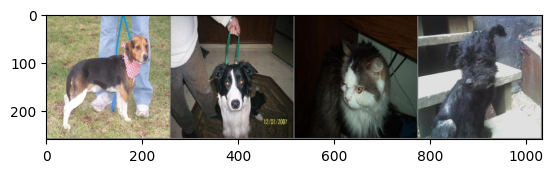

dog   dog   cat   dog  


In [ ]:

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Define the convolution nn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
class AnimalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)  # (256-5+2*2)/1 +1 = 256
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 5, padding=2)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Classifier
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # After 4 pooling layers: 256/(2^4) = 16
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)  # 3 output classes

    def forward(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Classifier
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
net = AnimalClassifier().to(device)

Define a loss function and optimizer

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 4

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data


        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 1.173
[1,   400] loss: 1.032
[1,   600] loss: 0.937
[2,   200] loss: 0.938
[2,   400] loss: 0.874
[2,   600] loss: 0.929
[3,   200] loss: 0.936
[3,   400] loss: 0.866
[3,   600] loss: 0.875
[4,   200] loss: 0.871
[4,   400] loss: 0.869
[4,   600] loss: 0.866
Finished Training


Save the model

In [ ]:
torch.save(net.state_dict(), 'Animalclassifier.pth')

Test

In [ ]:
detaiter = iter(testloader)
images, labels = next(dataiter)

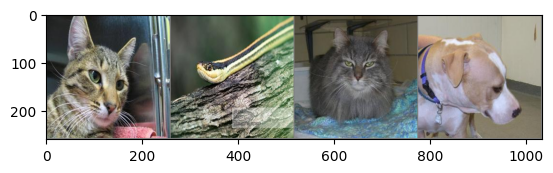

GroundTruth:  cat   snake cat   dog  


In [ ]:
imshow(torchvision.utils.make_grid(images)  )
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Reload

In [ ]:
net = AnimalClassifier()
net.load_state_dict(torch.load('Animalclassifier.pth',weights_only=True))

<All keys matched successfully>

Output

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   snake dog   dog  


In [ ]:
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')



Test Accuracy: 62.87%


In [ ]:
class_correct = [0] * 3
class_total = [0] * 3

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ['cat', 'dog', 'snake']
for i in range(3):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i]/class_total[i]:.2f}%')

Accuracy of cat: 81.90%
Accuracy of dog: 33.50%
Accuracy of snake: 73.20%
